# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# Append big_vision code to python import path
if "big_vision" not in sys.path:
  sys.path.append("/opt/big_vision")

print(f"System path: {sys.path}")

System path: ['/opt/big_vision', '/opt/gemma/examples', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '__editable__.flax-0.8.5.finder.__path_hook__', '/opt/pip/src', '/opt/panopticapi', '/opt/flaxformer', '/opt/common_loop_utils', '/opt/jaxlib', '/opt/gemma', '/usr/lib/python3/dist-packages', '/opt/big_vision']


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [2]:
import os

# Note: set the env vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

#### ここに自分のユーザー名とキーを書く! ####
os.environ["KAGGLE_USERNAME"] = 'xxxxxxx'
os.environ["KAGGLE_KEY"] = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [3]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  #### 変更点: kagglehubを使ってモデルデータをダウンロードする ####
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
print(f"Data path: {DATA_DIR}")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Tokenizer path: ./paligemma_tokenizer.model
Data path: ./longcap100


## Notebook

In [4]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU
tf.config.set_visible_devices([], "GPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

2024-08-20 15:55:55.898972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2893/961542416.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
2024-08-20 15:55:57.064113: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


JAX version:  0.4.30.dev20240611+11370b758
JAX platform: gpu
JAX devices:  1


In [5]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)
#### 変更点: MODEL_PATHの不要な変更があったのでコメントアウトした ####
#MODEL_PATH = "./pt_224.npz"

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [6]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [7]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [8]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



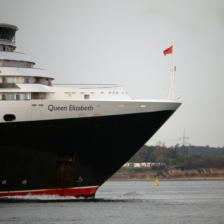
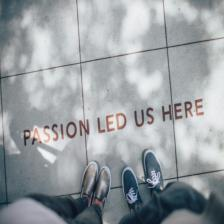
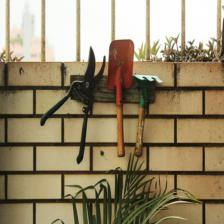
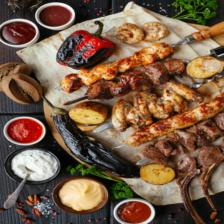
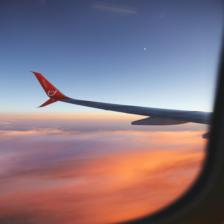
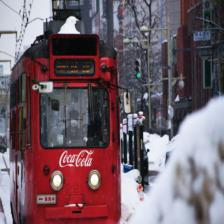
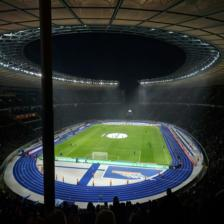
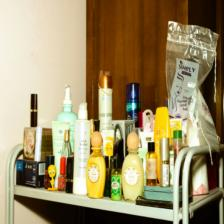

In [9]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [10]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

Model predictions



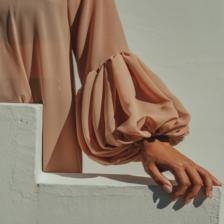
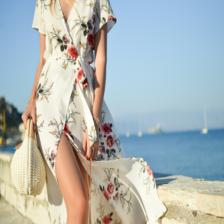
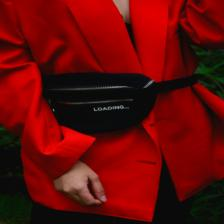
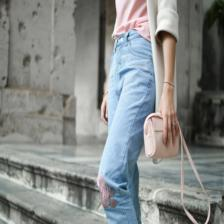
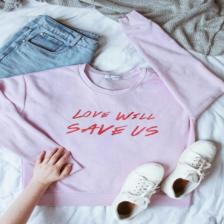
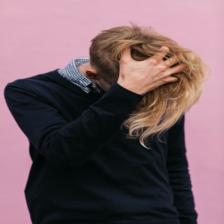
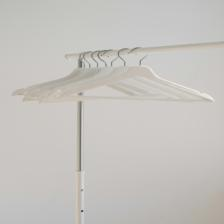
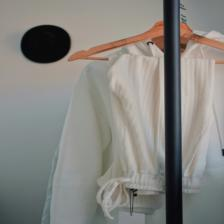
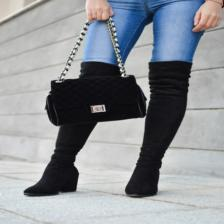
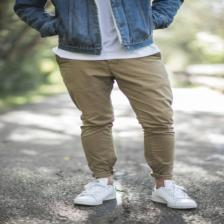

CPU times: user 5.24 s, sys: 729 ms, total: 5.96 s
Wall time: 8.33 s


In [11]:
%%time

# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

2024-08-20 15:56:19.568509: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 3.07GiB (3297400220 bytes) by rematerialization; only reduced to 8.32GiB (8935348568 bytes), down from 8.32GiB (8935354704 bytes) originally


step:  1/256   lr: 0.00115   loss: 2.5334
step:  2/256   lr: 0.00231   loss: 2.5825
step:  3/256   lr: 0.00346   loss: 2.4995
step:  4/256   lr: 0.00462   loss: 1.7944
step:  5/256   lr: 0.00577   loss: 1.2981
step:  6/256   lr: 0.00692   loss: 1.7931
step:  7/256   lr: 0.00808   loss: 1.5667
step:  8/256   lr: 0.00923   loss: 1.5289
step:  9/256   lr: 0.01038   loss: 1.4510
step: 10/256   lr: 0.01154   loss: 1.6823
step: 11/256   lr: 0.01269   loss: 1.0804
step: 12/256   lr: 0.01385   loss: 1.1762
step: 13/256   lr: 0.01500   loss: 1.4802
step: 14/256   lr: 0.01615   loss: 1.2003
step: 15/256   lr: 0.01731   loss: 1.3110
step: 16/256   lr: 0.01846   loss: 1.6267
step: 17/256   lr: 0.01962   loss: 1.2537
step: 18/256   lr: 0.02077   loss: 1.3921
step: 19/256   lr: 0.02192   loss: 1.6528
step: 20/256   lr: 0.02308   loss: 1.8740
step: 21/256   lr: 0.02423   loss: 1.8595
step: 22/256   lr: 0.02538   loss: 1.4129
step: 23/256   lr: 0.02654   loss: 1.5177
step: 24/256   lr: 0.02769   loss:


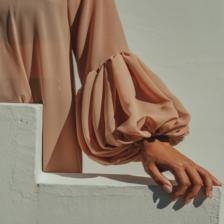
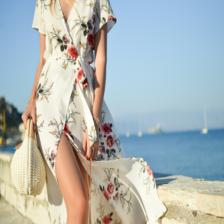
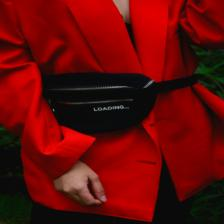
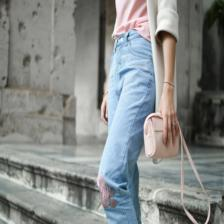
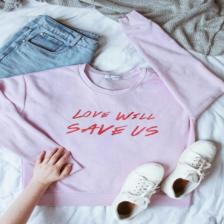
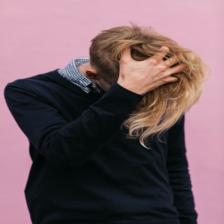
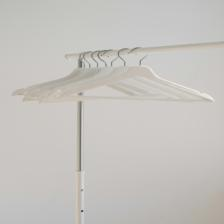
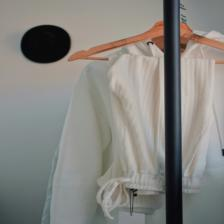

step: 33/256   lr: 0.02993   loss: 1.5442
step: 34/256   lr: 0.02991   loss: 1.6031
step: 35/256   lr: 0.02989   loss: 2.0292
step: 36/256   lr: 0.02986   loss: 1.4999
step: 37/256   lr: 0.02983   loss: 1.2728
step: 38/256   lr: 0.02980   loss: 1.1846
step: 39/256   lr: 0.02977   loss: 1.1659
step: 40/256   lr: 0.02973   loss: 1.3732
step: 41/256   lr: 0.02969   loss: 1.2661
step: 42/256   lr: 0.02965   loss: 1.3230
step: 43/256   lr: 0.02960   loss: 1.4188
step: 44/256   lr: 0.02955   loss: 1.4293
step: 45/256   lr: 0.02950   loss: 1.5178
step: 46/256   lr: 0.02945   loss: 1.1653
step: 47/256   lr: 0.02939   loss: 0.7797
step: 48/256   lr: 0.02933   loss: 0.6620
step: 49/256   lr: 0.02927   loss: 1.3942
step: 50/256   lr: 0.02921   loss: 0.9264
step: 51/256   lr: 0.02914   loss: 1.1345
step: 52/256   lr: 0.02907   loss: 1.1583
step: 53/256   lr: 0.02900   loss: 1.3439
step: 54/256   lr: 0.02893   loss: 1.4052
step: 55/256   lr: 0.02885   loss: 0.7334
step: 56/256   lr: 0.02877   loss:


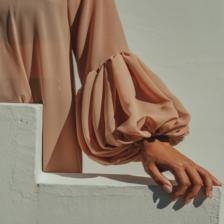
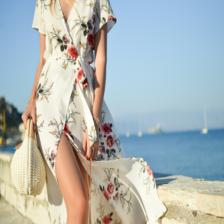
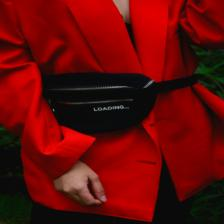
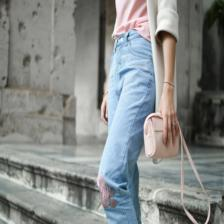
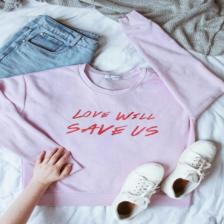
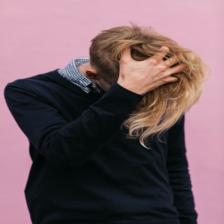
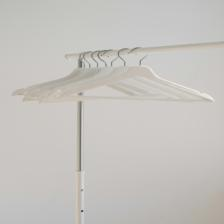
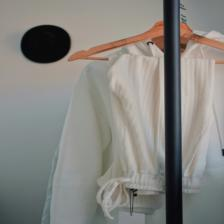

step: 65/256   lr: 0.02794   loss: 1.1650
step: 66/256   lr: 0.02783   loss: 1.0362
step: 67/256   lr: 0.02773   loss: 1.0008
step: 68/256   lr: 0.02762   loss: 0.9177
step: 69/256   lr: 0.02751   loss: 0.9069
step: 70/256   lr: 0.02739   loss: 1.0164
step: 71/256   lr: 0.02728   loss: 0.7265
step: 72/256   lr: 0.02716   loss: 1.2239
step: 73/256   lr: 0.02704   loss: 1.0469
step: 74/256   lr: 0.02692   loss: 0.8710
step: 75/256   lr: 0.02679   loss: 0.8333
step: 76/256   lr: 0.02666   loss: 1.1507
step: 77/256   lr: 0.02653   loss: 1.0363
step: 78/256   lr: 0.02640   loss: 0.8380
step: 79/256   lr: 0.02627   loss: 0.8177
step: 80/256   lr: 0.02613   loss: 0.9147
step: 81/256   lr: 0.02600   loss: 1.3506
step: 82/256   lr: 0.02586   loss: 0.9120
step: 83/256   lr: 0.02571   loss: 1.1503
step: 84/256   lr: 0.02557   loss: 0.9104
step: 85/256   lr: 0.02542   loss: 1.0369
step: 86/256   lr: 0.02528   loss: 0.9492
step: 87/256   lr: 0.02513   loss: 1.0369
step: 88/256   lr: 0.02498   loss:


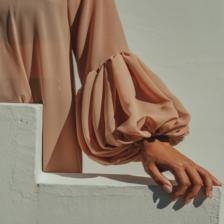
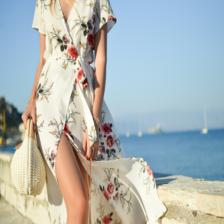
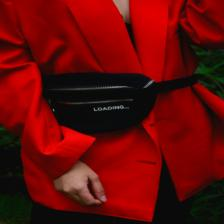
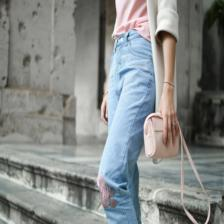
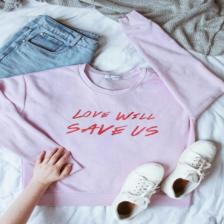
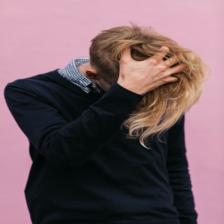
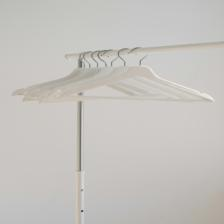
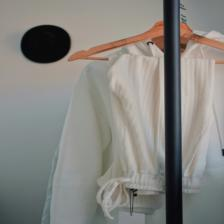

step: 97/256   lr: 0.02353   loss: 0.6438
step: 98/256   lr: 0.02337   loss: 0.5194
step: 99/256   lr: 0.02320   loss: 0.4935
step: 100/256   lr: 0.02302   loss: 0.4672
step: 101/256   lr: 0.02285   loss: 0.7102
step: 102/256   lr: 0.02268   loss: 0.5729
step: 103/256   lr: 0.02250   loss: 0.5029
step: 104/256   lr: 0.02232   loss: 0.5363
step: 105/256   lr: 0.02214   loss: 0.5113
step: 106/256   lr: 0.02196   loss: 0.4631
step: 107/256   lr: 0.02178   loss: 0.4373
step: 108/256   lr: 0.02160   loss: 0.8805
step: 109/256   lr: 0.02142   loss: 0.5543
step: 110/256   lr: 0.02123   loss: 0.5658
step: 111/256   lr: 0.02105   loss: 0.7672
step: 112/256   lr: 0.02086   loss: 0.6902
step: 113/256   lr: 0.02067   loss: 0.4422
step: 114/256   lr: 0.02048   loss: 0.4817
step: 115/256   lr: 0.02029   loss: 0.5995
step: 116/256   lr: 0.02010   loss: 0.6371
step: 117/256   lr: 0.01991   loss: 0.6390
step: 118/256   lr: 0.01971   loss: 0.7707
step: 119/256   lr: 0.01952   loss: 1.0020
step: 120/256 


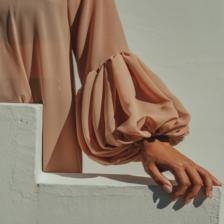
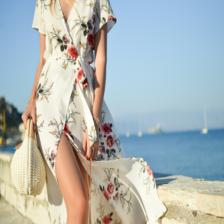
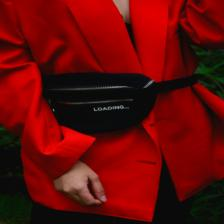
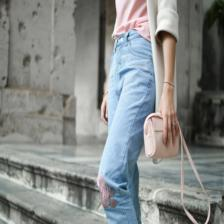
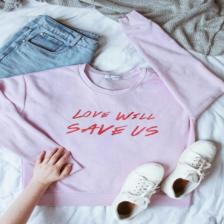
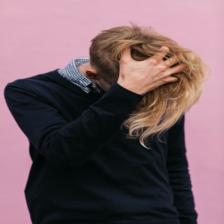
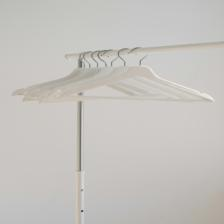
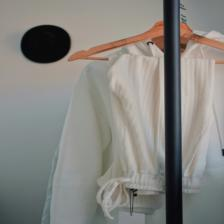

step: 129/256   lr: 0.01754   loss: 0.8093
step: 130/256   lr: 0.01734   loss: 0.5728
step: 131/256   lr: 0.01713   loss: 0.4109
step: 132/256   lr: 0.01693   loss: 0.7471
step: 133/256   lr: 0.01673   loss: 0.5854
step: 134/256   lr: 0.01653   loss: 0.4571
step: 135/256   lr: 0.01632   loss: 0.6477
step: 136/256   lr: 0.01612   loss: 0.4484
step: 137/256   lr: 0.01592   loss: 0.4042
step: 138/256   lr: 0.01571   loss: 0.3237
step: 139/256   lr: 0.01551   loss: 0.2735
step: 140/256   lr: 0.01531   loss: 0.4379
step: 141/256   lr: 0.01510   loss: 0.2893
step: 142/256   lr: 0.01490   loss: 0.2072
step: 143/256   lr: 0.01469   loss: 0.1358
step: 144/256   lr: 0.01449   loss: 0.3160
step: 145/256   lr: 0.01429   loss: 0.2542
step: 146/256   lr: 0.01408   loss: 0.2362
step: 147/256   lr: 0.01388   loss: 0.2073
step: 148/256   lr: 0.01368   loss: 0.2193
step: 149/256   lr: 0.01347   loss: 0.3773
step: 150/256   lr: 0.01327   loss: 0.3807
step: 151/256   lr: 0.01307   loss: 0.3634
step: 152/2


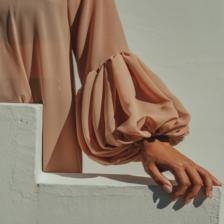
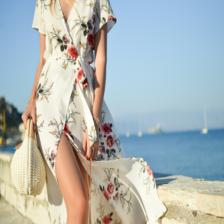
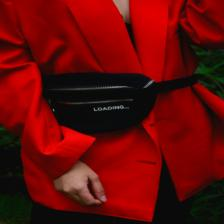
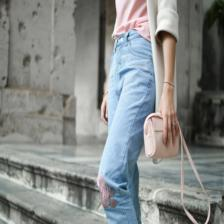
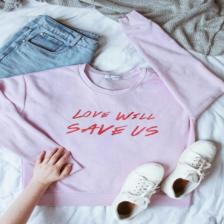
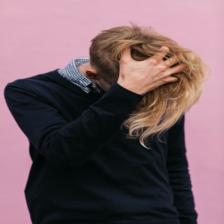
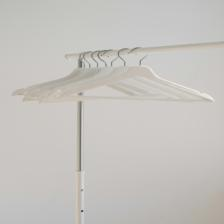
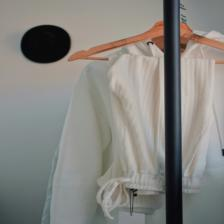

step: 161/256   lr: 0.01107   loss: 0.1548
step: 162/256   lr: 0.01087   loss: 0.2296
step: 163/256   lr: 0.01068   loss: 0.3637
step: 164/256   lr: 0.01048   loss: 0.2619
step: 165/256   lr: 0.01029   loss: 0.2619
step: 166/256   lr: 0.01009   loss: 0.3214
step: 167/256   lr: 0.00990   loss: 0.3941
step: 168/256   lr: 0.00971   loss: 0.2252
step: 169/256   lr: 0.00952   loss: 0.3739
step: 170/256   lr: 0.00933   loss: 0.1014
step: 171/256   lr: 0.00914   loss: 0.2421
step: 172/256   lr: 0.00895   loss: 0.2750
step: 173/256   lr: 0.00877   loss: 0.3242
step: 174/256   lr: 0.00858   loss: 0.2579
step: 175/256   lr: 0.00840   loss: 0.3801
step: 176/256   lr: 0.00822   loss: 0.2914
step: 177/256   lr: 0.00804   loss: 0.3627
step: 178/256   lr: 0.00786   loss: 0.2392
step: 179/256   lr: 0.00768   loss: 0.3468
step: 180/256   lr: 0.00750   loss: 0.3745
step: 181/256   lr: 0.00732   loss: 0.1393
step: 182/256   lr: 0.00715   loss: 0.0629
step: 183/256   lr: 0.00698   loss: 0.0698
step: 184/2


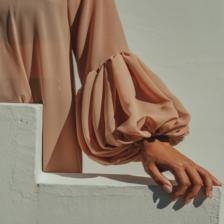
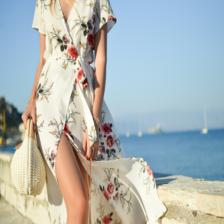
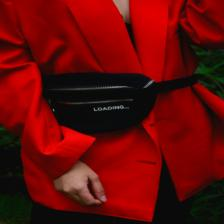
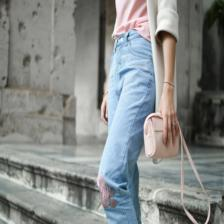
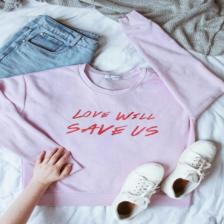
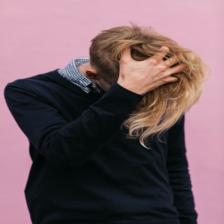
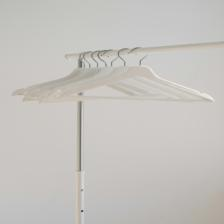
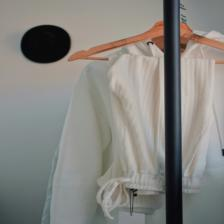

step: 193/256   lr: 0.00533   loss: 0.0970
step: 194/256   lr: 0.00518   loss: 0.0643
step: 195/256   lr: 0.00502   loss: 0.0680
step: 196/256   lr: 0.00487   loss: 0.1442
step: 197/256   lr: 0.00472   loss: 0.1373
step: 198/256   lr: 0.00458   loss: 0.1137
step: 199/256   lr: 0.00443   loss: 0.0746
step: 200/256   lr: 0.00429   loss: 0.1820
step: 201/256   lr: 0.00414   loss: 0.1864
step: 202/256   lr: 0.00400   loss: 0.0751
step: 203/256   lr: 0.00387   loss: 0.1229
step: 204/256   lr: 0.00373   loss: 0.1799
step: 205/256   lr: 0.00360   loss: 0.1987
step: 206/256   lr: 0.00347   loss: 0.0306
step: 207/256   lr: 0.00334   loss: 0.0422
step: 208/256   lr: 0.00321   loss: 0.0732
step: 209/256   lr: 0.00308   loss: 0.0840
step: 210/256   lr: 0.00296   loss: 0.1023
step: 211/256   lr: 0.00284   loss: 0.0627
step: 212/256   lr: 0.00272   loss: 0.1590
step: 213/256   lr: 0.00261   loss: 0.1581
step: 214/256   lr: 0.00249   loss: 0.1082
step: 215/256   lr: 0.00238   loss: 0.1573
step: 216/2


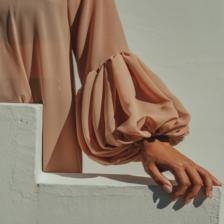
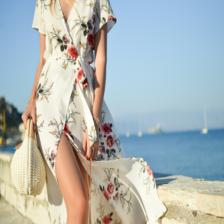
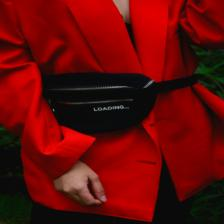
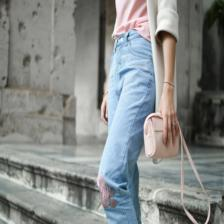
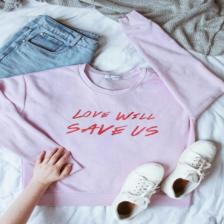
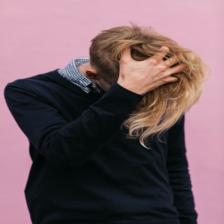
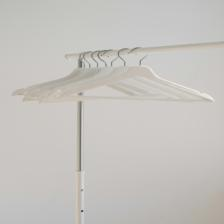
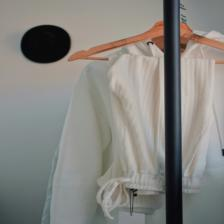

step: 225/256   lr: 0.00140   loss: 0.0625
step: 226/256   lr: 0.00131   loss: 0.0311
step: 227/256   lr: 0.00123   loss: 0.0381
step: 228/256   lr: 0.00115   loss: 0.1304
step: 229/256   lr: 0.00107   loss: 0.1103
step: 230/256   lr: 0.00100   loss: 0.0664
step: 231/256   lr: 0.00093   loss: 0.0849
step: 232/256   lr: 0.00086   loss: 0.1356
step: 233/256   lr: 0.00079   loss: 0.1273
step: 234/256   lr: 0.00073   loss: 0.0199
step: 235/256   lr: 0.00067   loss: 0.0460
step: 236/256   lr: 0.00061   loss: 0.0423
step: 237/256   lr: 0.00055   loss: 0.0686
step: 238/256   lr: 0.00050   loss: 0.0490
step: 239/256   lr: 0.00045   loss: 0.1459
step: 240/256   lr: 0.00040   loss: 0.1004
step: 241/256   lr: 0.00035   loss: 0.0596
step: 242/256   lr: 0.00031   loss: 0.0504
step: 243/256   lr: 0.00027   loss: 0.0604
step: 244/256   lr: 0.00023   loss: 0.1519
step: 245/256   lr: 0.00020   loss: 0.0458
step: 246/256   lr: 0.00017   loss: 0.0303
step: 247/256   lr: 0.00014   loss: 0.0862
step: 248/2


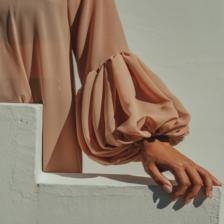
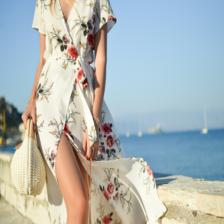
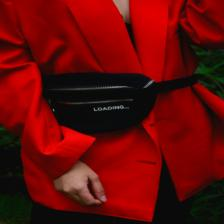
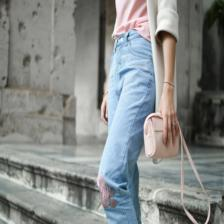
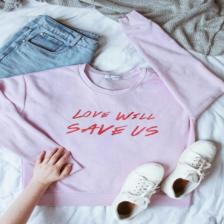
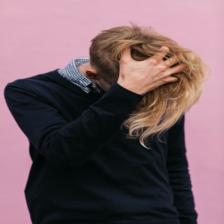
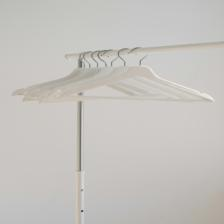
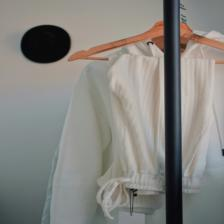

CPU times: user 50.4 s, sys: 3.32 s, total: 53.7 s
Wall time: 3min 54s


In [12]:
%%time

# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#

#### 変更点: 12GBのVRAMで動かすために、バッチサイズを8から2に変更した ####
BATCH_SIZE = 2
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=8, batch_size=8):
      html_out += render_example(image, caption)
    display(HTML(html_out))


Model predictions



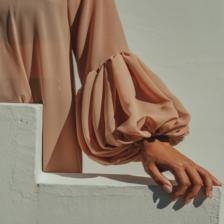
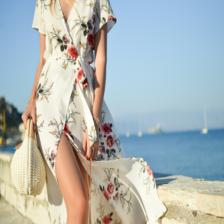
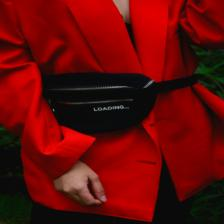
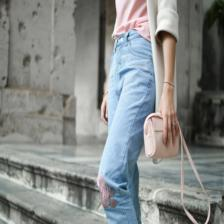
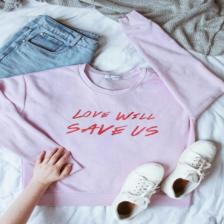
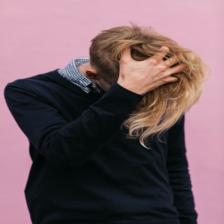
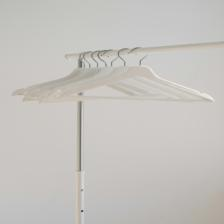
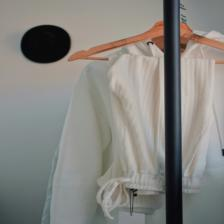
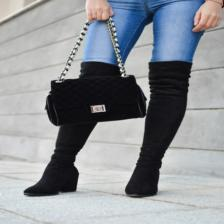
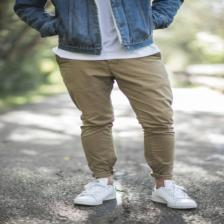

CPU times: user 1.29 s, sys: 186 ms, total: 1.48 s
Wall time: 10.3 s


In [13]:
%%time

# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))
